# Import Packages

In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import zipfile
import urllib.request
import os
from google.colab.patches import cv2_imshow

# Download Data

**We will use dataset Dog and Cat from Microsoft-Kaggle**

In [2]:
# download data
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   136M      0  0:00:05  0:00:05 --:--:--  140M


In [3]:
# Upzip file 
zip_ref = zipfile.ZipFile('/content/kagglecatsanddogs_5340.zip', "r")
zip_ref.extractall('./output/')
zip_ref.close()

In [4]:
path = './output/PetImages'
print(os.listdir(path))

print('Total dog images :', len(os.listdir('./output/PetImages/Dog') ))
print('Total cat images :', len(os.listdir('./output/PetImages/Cat') ))

['Cat', 'Dog']
Total dog images : 12501
Total cat images : 12501


# Pre-processing Data

**Filter out corrupted image**

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(path, folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            f = open(file_path, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in f.peek(10)
        finally:
            f.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(file_path)

print("Deleted %d images" % num_skipped)

print('Total dog images :', len(os.listdir('./output/PetImages/Dog') ))
print('Total cat images :', len(os.listdir('./output/PetImages/Cat') ))

Deleted 1590 images
Total dog images : 11670
Total cat images : 11742


**Hyperparameters**

In [19]:
image_size = (150,150)
batch_size = 32
buffer_size = 32
epochs = 50

**Create Train and Validation dataset**

In [7]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split =0.2,
    subset = "training",
    seed = 1234,
    image_size = image_size,
    batch_size = batch_size
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split =0.2,
    subset = "validation",
    seed = 1234,
    image_size = image_size,
    batch_size = batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [8]:
print(type(train_dataset))
print(len(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
586


**Visualisation Data**

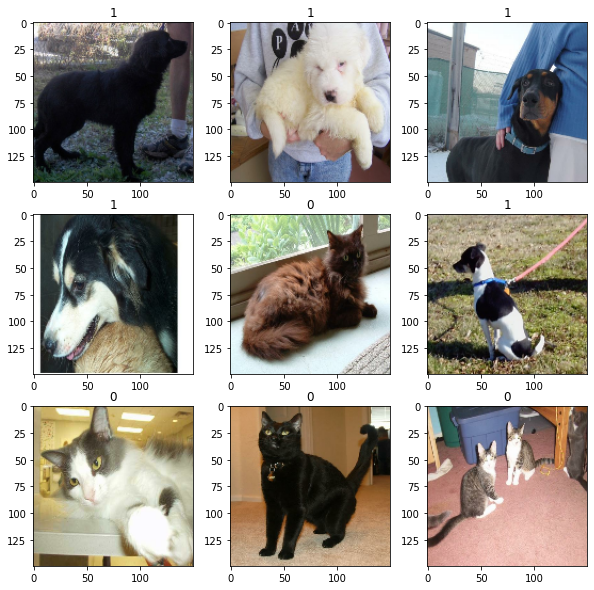

In [9]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))

**Data Augmentation**

In [10]:
data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      #layers.RandomTranslation(height_factor=(-0.1, 0.1),width_factor=(-0.1, 0.1))
])

Visualize data augmented

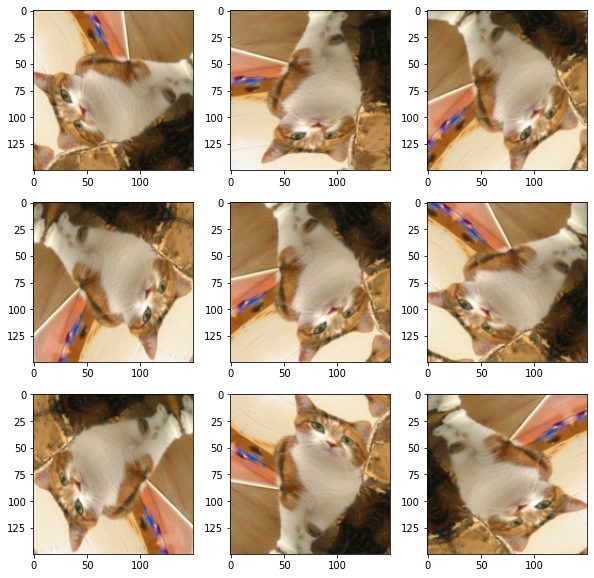

In [11]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

**Configure the dataset for performance**

In [13]:
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
validation_dataset = validation_dataset.prefetch(buffer_size=buffer_size)

# Define Model

In [17]:
def build_model(input_shape, num_class):
  inputs = keras.Input(shape=input_shape)

  x = data_augmentation(inputs) # Add data augmentation block
  x = layers.Rescaling(1.0 / 255)(x) # Data Standardizing
  x = layers.Conv2D(32,(3,3), strides=2, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(64,(3,3),strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x_residual = x
  for size in [128,256,512,728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size,(3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size,(3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)
    residual = layers.Conv2D(size, 1,strides=2, padding='same')(x_residual) # Project residual
    x = layers.add([x, residual]) # Add back residual
    x_residual = x
  
  x = layers.SeparableConv2D(1024,(3,3), padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)

  if num_class == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_class
  
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

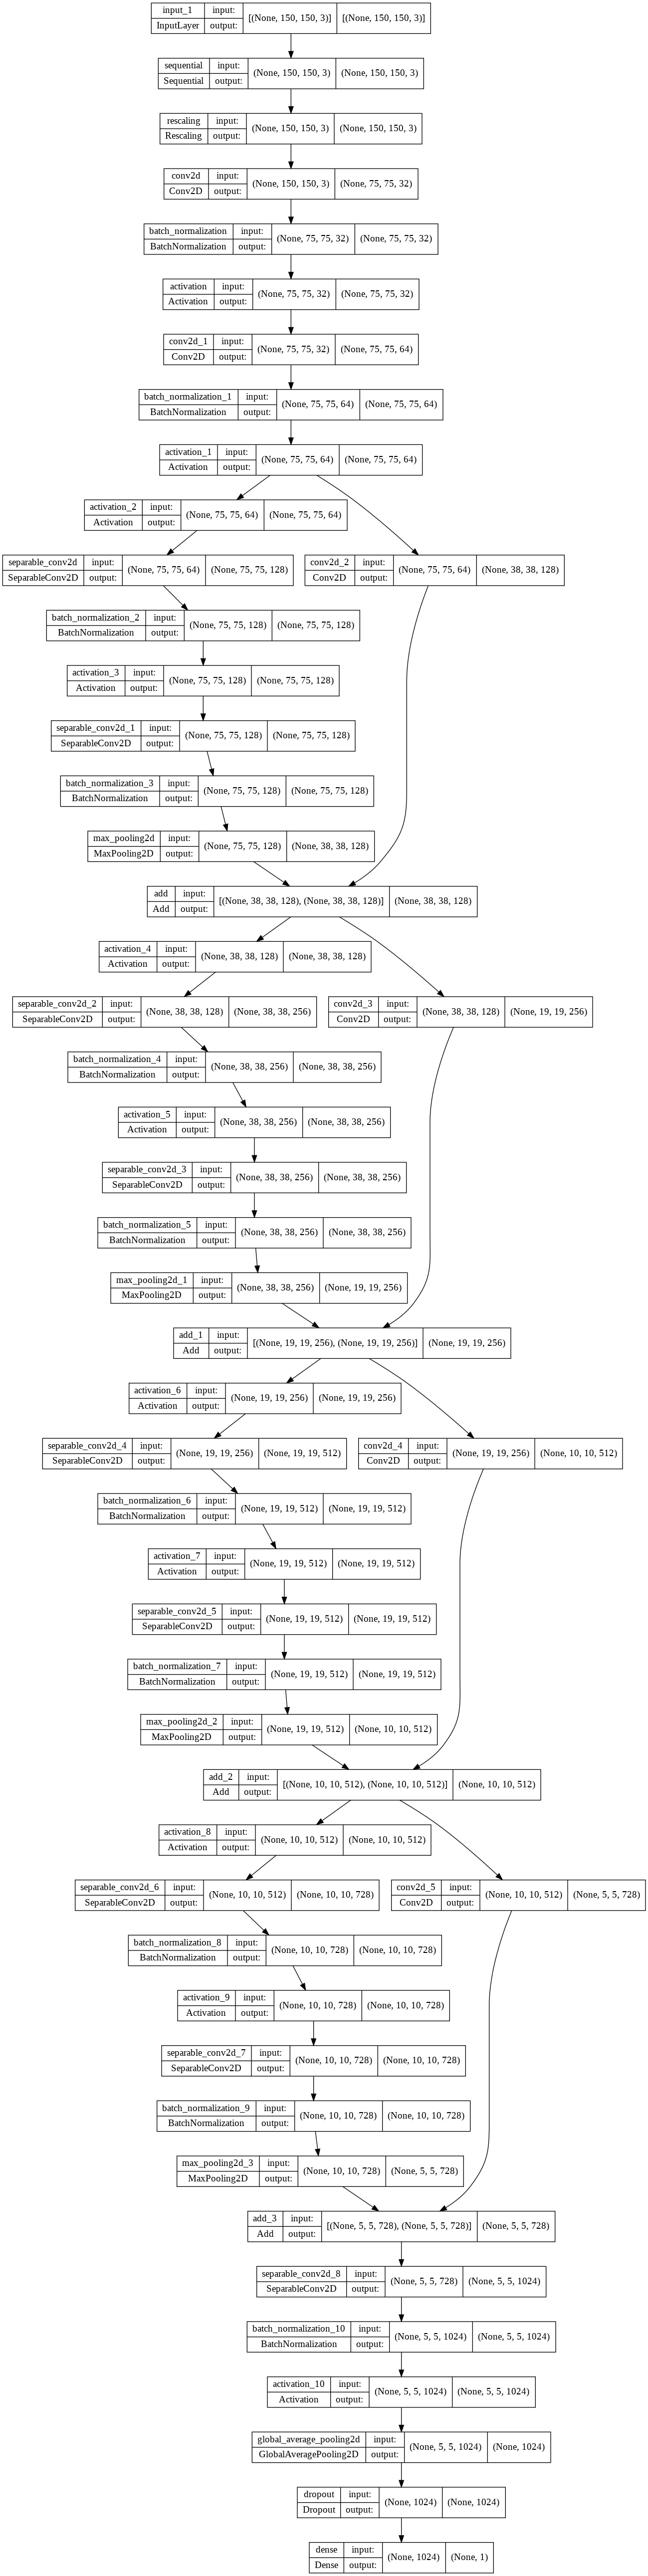

In [18]:
model = build_model(input_shape=image_size + (3,), num_class=2)
keras.utils.plot_model(model, show_shapes=True)

# Train Model

**Set up Callback**

In [21]:
earlystop=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=0, mode='auto')

callbacks = [earlystop]

In [24]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics = ['accuracy'])

history = model.fit(train_dataset, epochs=epochs, callbacks = callbacks, validation_data=validation_dataset)

Epoch 1/50
586/586 [==============================] - 115s 191ms/step - loss: 0.5965 - accuracy: 0.6872 - val_loss: 0.8125 - val_accuracy: 0.5852
Epoch 2/50
586/586 [==============================] - 111s 189ms/step - loss: 0.5039 - accuracy: 0.7558 - val_loss: 1.8267 - val_accuracy: 0.5235
Epoch 3/50
586/586 [==============================] - 112s 191ms/step - loss: 0.4543 - accuracy: 0.7935 - val_loss: 0.5632 - val_accuracy: 0.7176
Epoch 4/50
586/586 [==============================] - 112s 190ms/step - loss: 0.4144 - accuracy: 0.8149 - val_loss: 0.4117 - val_accuracy: 0.8063
Epoch 5/50
586/586 [==============================] - 111s 189ms/step - loss: 0.3837 - accuracy: 0.8300 - val_loss: 0.3714 - val_accuracy: 0.8394
Epoch 6/50
586/586 [==============================] - 112s 191ms/step - loss: 0.3570 - accuracy: 0.8413 - val_loss: 0.5433 - val_accuracy: 0.7563
Epoch 7/50
586/586 [==============================] - 114s 194ms/step - loss: 0.3394 - accuracy: 0.8516 - val_loss: 0.6025 -

# Results and Plots

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

**Plot accuracy**

<Figure size 432x288 with 0 Axes>

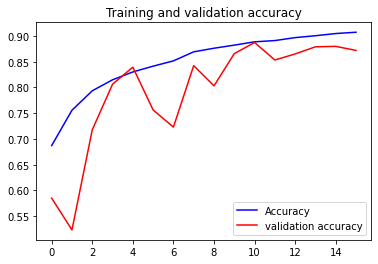

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot training and validation accuracy
plt.plot(epochs, accuracy,color='blue')
plt.plot(epochs, val_accuracy, color = 'red')
plt.legend(['Accuracy', 'validation accuracy'])
plt.title ('Training and validation accuracy')
plt.figure()

**Plot loss**

<Figure size 432x288 with 0 Axes>

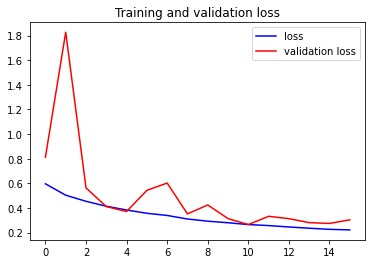

<Figure size 432x288 with 0 Axes>

In [33]:
# Plot training and validation loss
plt.plot(epochs, loss,color='blue')
plt.plot(epochs, val_loss, color = 'red')
plt.legend(['loss', 'validation loss'])
plt.title ('Training and validation loss')
plt.figure()

**Prediction on test set**

In [34]:
val_loss, val_acc = model.evaluate(validation_dataset)

print("Loss : ", val_loss)
print("Accuracy : ", val_acc)

147/147 [==============================] - 6s 41ms/step - loss: 0.3041 - accuracy: 0.8718
Loss :  0.3040603697299957
Accuracy :  0.8718496561050415


**Prediction on one image**

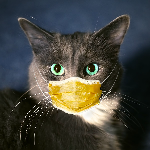

This image is 93.35 percent cat and 6.65 percent dog.


In [39]:
img = keras.preprocessing.image.load_img(
    "/content/cat.jpg", target_size=image_size
)

img_array = keras.preprocessing.image.img_to_array(img)
cv2_imshow(img_array)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

pred = model.predict(img_array)
score = pred[0]

print("This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score))

# Save and Load Model

In [40]:
!pip install -q pyyaml h5py

In [46]:
# save model
model.save('dog_cat_cnn_model.h5')

# load model
new_model = keras.models.load_model('/content/dog_cat_cnn_model.h5')

In [47]:
pred = new_model.predict(img_array)
score = pred[0]

print("This image is %.2f percent cat and %.2f percent dog." % (100 * (1 - score), 100 * score))

This image is 93.35 percent cat and 6.65 percent dog.
